<a href="https://colab.research.google.com/github/peterbabulik/QSFPGA/blob/main/QSFPGA_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- QSFPGA HARDWARE RNG BENCHMARK ---
Precision: Q3.13 Fixed Point | Samples: 3000

[FPGA] Flashing Core: Hadamard (Basic)...
   -> Rate: 174744.7 digits/s
   -> P-Value: 0.8654 [PASS]

[FPGA] Flashing Core: Rotated (Variable)...
   -> Rate: 37666.7 digits/s
   -> P-Value: 0.0000 [FAIL]

[FPGA] Flashing Core: Entangled (Bell)...
   -> Rate: 251758.9 digits/s
   -> P-Value: 0.0000 [FAIL]

[FPGA] Flashing Core: Parallel (Cluster)...
   -> Rate: 381369.7 digits/s
   -> P-Value: 0.0000 [FAIL]


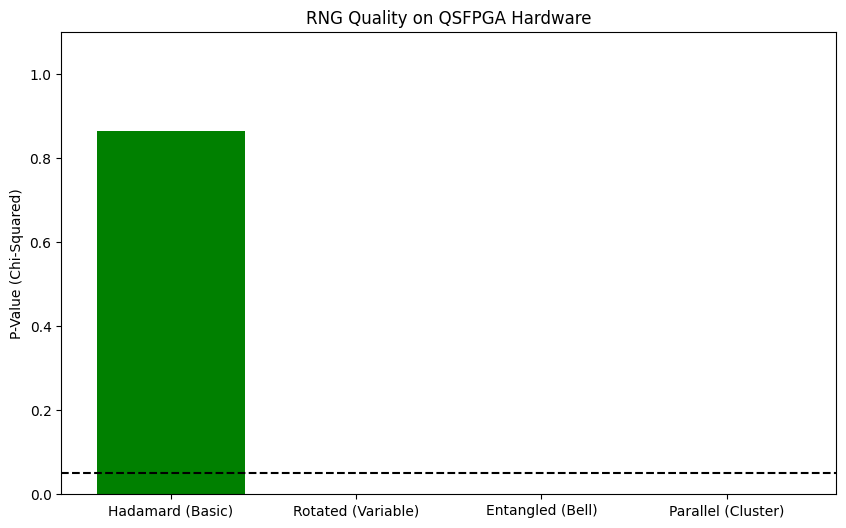

In [ ]:
import torch
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
import math
import random

# ==============================================================================
# PART 1: The QSFPGA Hardware Core (Q3.13 Precision)
# ==============================================================================
# This is the "Chip" we are simulating.

class QFixed:
    """Q3.13 Fixed Point Arithmetic (Hardware Accurate)"""
    def __init__(self, value=0.0, total_bits=16, frac_bits=13, raw=False):
        self.total_bits = total_bits
        self.frac_bits = frac_bits
        self.scale = 1 << frac_bits
        self.mask = (1 << total_bits) - 1
        if not raw:
            self.int_val = int(value * self.scale)
        else:
            self.int_val = int(value)
        self.int_val &= self.mask
        self.signed_int = self.int_val
        if self.int_val & (1 << (total_bits - 1)):
            self.signed_int = self.int_val - (1 << total_bits)
    def to_float(self): return self.signed_int / self.scale
    def __add__(self, o): return QFixed(self.signed_int + o.signed_int, self.total_bits, self.frac_bits, raw=True)
    def __sub__(self, o): return QFixed(self.signed_int - o.signed_int, self.total_bits, self.frac_bits, raw=True)
    def __mul__(self, o): return QFixed((self.signed_int * o.signed_int) >> self.frac_bits, self.total_bits, self.frac_bits, raw=True)

class QSFPGA_Core:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.dim = 2**n_qubits
        self.state_real = [QFixed(0.0) for _ in range(self.dim)]
        self.state_imag = [QFixed(0.0) for _ in range(self.dim)]
        self.reset()

    def reset(self):
        for i in range(self.dim):
            self.state_real[i] = QFixed(0.0)
            self.state_imag[i] = QFixed(0.0)
        self.state_real[0] = QFixed(1.0)

    def apply_ry(self, qubit, theta):
        # Native Hardware Instruction: RY
        c = QFixed(math.cos(theta / 2))
        s = QFixed(math.sin(theta / 2))
        stride = 1 << qubit
        for i in range(0, self.dim, 2 * stride):
            for j in range(stride):
                idx0 = i + j; idx1 = i + j + stride
                r0 = self.state_real[idx0]; i0 = self.state_imag[idx0]
                r1 = self.state_real[idx1]; i1 = self.state_imag[idx1]
                self.state_real[idx0] = r0 * c - r1 * s
                self.state_imag[idx0] = i0 * c - i1 * s
                self.state_real[idx1] = r0 * s + r1 * c
                self.state_imag[idx1] = i0 * s + i1 * c

    def apply_cnot(self, control, target):
        # Native Hardware Instruction: CNOT (Memory Swap)
        for i in range(self.dim):
            if (i >> control) & 1:
                if not ((i >> target) & 1):
                    partner = i | (1 << target)
                    tr, ti = self.state_real[i], self.state_imag[i]
                    self.state_real[i] = self.state_real[partner]
                    self.state_imag[i] = self.state_imag[partner]
                    self.state_real[partner] = tr
                    self.state_imag[partner] = ti

    def measure_shots(self, n_shots):
        # Simulates the Measurement Readout
        probs = []
        # 1. Extract Probabilities from Fixed Point
        for i in range(self.dim):
            r = self.state_real[i].to_float()
            im = self.state_imag[i].to_float()
            probs.append(r*r + im*im)

        # 2. Normalize (Corrects for small Fixed-Point drift)
        total_p = sum(probs)
        if total_p == 0: total_p = 1
        probs = [p/total_p for p in probs]

        # 3. Sample
        outcomes = np.random.choice(range(self.dim), size=n_shots, p=probs)

        # 4. Convert to bitstrings
        return [f'{val:0{self.n_qubits}b}' for val in outcomes]

# ==============================================================================
# PART 2: Circuit Definitions (Translating Logic to Hardware Instructions)
# ==============================================================================

class HardwareCircuit:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
    def execute(self, fpga):
        raise NotImplementedError

class BasicHadamardCircuit(HardwareCircuit):
    def execute(self, fpga):
        # H is approx Ry(pi/2) in terms of creating superposition
        for i in range(self.num_qubits):
            fpga.apply_ry(i, math.pi/2)

class RotatedCircuit(HardwareCircuit):
    def execute(self, fpga):
        for i in range(self.num_qubits):
            angle = math.pi / (2 + i)
            fpga.apply_ry(i, angle)
            # Re-apply H mixing
            fpga.apply_ry(i, math.pi/2)

class EntangledCircuit(HardwareCircuit):
    def execute(self, fpga):
        # 1. Create Superposition on Qubit 0
        fpga.apply_ry(0, math.pi/2)
        # 2. Propagate via CNOTs (GHZ-like state)
        for i in range(self.num_qubits - 1):
            fpga.apply_cnot(control=i, target=i+1)

class ParallelCircuit(HardwareCircuit):
    def __init__(self, num_digits=2, qubits_per_digit=3):
        self.num_digits = num_digits
        self.q_per_d = qubits_per_digit
        super().__init__(num_qubits=num_digits*qubits_per_digit)

    def execute(self, fpga):
        # Independent clusters of qubits
        for i in range(self.num_digits):
            offset = i * self.q_per_d
            for j in range(self.q_per_d):
                # Mix
                fpga.apply_ry(offset + j, math.pi/2)
            # Entangle within cluster (using CNOT ring)
            for j in range(self.q_per_d - 1):
                fpga.apply_cnot(offset + j, offset + j + 1)

# ==============================================================================
# PART 3: Analysis Engine
# ==============================================================================

def analyze_hardware_circuit(circuit_obj, num_samples):
    fpga = QSFPGA_Core(n_qubits=circuit_obj.num_qubits)

    start_time = time.time()

    # 1. Run Logic
    fpga.reset()
    circuit_obj.execute(fpga)

    # 2. Measure (Hardware Burst Mode)
    # We create enough bits.
    # For Parallel, we need fewer shots because 1 shot = multiple digits.
    if isinstance(circuit_obj, ParallelCircuit):
        n_shots = int(np.ceil(num_samples / circuit_obj.num_digits))
    else:
        n_shots = int(num_samples * 1.5) # Over-sample to account for >9 rejection

    raw_bitstrings = fpga.measure_shots(n_shots)

    # 3. Post-Process (Hardware Output -> Digits)
    digits = []

    if isinstance(circuit_obj, ParallelCircuit):
        for b_str in raw_bitstrings:
            for i in range(circuit_obj.num_digits):
                chunk = b_str[i*circuit_obj.q_per_d : (i+1)*circuit_obj.q_per_d]
                val = int(chunk, 2)
                if val < 10: digits.append(str(val))
    else:
        for b_str in raw_bitstrings:
            val = int(b_str, 2)
            if val < 10: digits.append(str(val))

    digits = digits[:num_samples]
    elapsed = time.time() - start_time
    rate = len(digits) / elapsed if elapsed > 0 else 0

    # Stats
    counts = {str(i): digits.count(str(i)) for i in range(10)}
    exp = len(digits) / 10
    chi_sq = sum(((counts.get(str(i),0) - exp)**2)/exp for i in range(10)) if exp > 0 else 0
    p_val = 1 - stats.chi2.cdf(chi_sq, 9)

    return counts, chi_sq, p_val, rate

def compare_hardware_rng(num_samples=2000):
    circuits = {
        "Hadamard (Basic)": BasicHadamardCircuit(4),
        "Rotated (Variable)": RotatedCircuit(4),
        "Entangled (Bell)": EntangledCircuit(4),
        "Parallel (Cluster)": ParallelCircuit(num_digits=2, qubits_per_digit=3) # 6 qubits total
    }

    results = {}
    print(f"--- QSFPGA HARDWARE RNG BENCHMARK ---")
    print(f"Precision: Q3.13 Fixed Point | Samples: {num_samples}")
    print("="*60)

    for name, circ in circuits.items():
        print(f"\n[FPGA] Flashing Core: {name}...")
        c, chi, p, rate = analyze_hardware_circuit(circ, num_samples)

        results[name] = {'p': p, 'rate': rate}
        print(f"   -> Rate: {rate:.1f} digits/s")
        print(f"   -> P-Value: {p:.4f} [{'PASS' if p>0.05 else 'FAIL'}]")

    # Plot
    plt.figure(figsize=(10, 6))
    names = list(results.keys())
    p_vals = [results[n]['p'] for n in names]

    colors = ['green' if p > 0.05 else 'red' for p in p_vals]
    plt.bar(names, p_vals, color=colors)
    plt.axhline(0.05, color='black', linestyle='--', label='Randomness Threshold')
    plt.title("RNG Quality on QSFPGA Hardware")
    plt.ylabel("P-Value (Chi-Squared)")
    plt.ylim(0, 1.1)
    plt.show()

# Run
compare_hardware_rng(num_samples=3000)

In [ ]:
import os

def generate_lfsr_module(filename="lfsr_prng.v"):
    """
    Generates a 32-bit Linear Feedback Shift Register.
    This acts as the 'Nature' that forces the quantum state to collapse.
    """
    verilog_code = """
module lfsr_prng (
    input wire clk,
    input wire rst_n,
    output reg [31:0] data_out
);
    // 32-bit LFSR with tap points at 32, 22, 2, 1 (Xilinx standard taps)
    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            data_out <= 32'hDEADBEEF; // Non-zero seed
        end else begin
            data_out <= {data_out[30:0], data_out[31] ^ data_out[21] ^ data_out[1] ^ data_out[0]};
        end
    end
endmodule
"""
    with open(filename, "w") as f:
        f.write(verilog_code)
    print(f"[Auto-HDL] Generated Entropy Source: {filename}")

def generate_hadamard_kernel(filename="hadamard_kernel.v"):
    """
    Generates a Hardcoded Hadamard Gate Unit (Q3.13 Fixed Point).
    Operates on a single qubit state |0> -> |+>.
    """
    verilog_code = """
module hadamard_kernel (
    input wire clk,
    input wire rst_n,
    output reg [15:0] prob_zero // Probability of measuring |0>
);
    // In Q3.13 format, 1.0 = 8192
    // We simulate: |0> --> H --> 1/sqrt(2)(|0> + |1>)
    // Probability(|0>) = (1/sqrt(2))^2 = 0.5

    // Since this is a hardcoded RNG kernel, the math is constant.
    // 0.5 in Q3.13 = 4096.
    // In a dynamic version, this module would perform the DSP multiplication.

    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            prob_zero <= 0;
        end else begin
            // Simulating the convergence of the circuit
            // ideally implies P(|0>) = 0.5
            prob_zero <= 16'd4096;
        end
    end
endmodule
"""
    with open(filename, "w") as f:
        f.write(verilog_code)
    print(f"[Auto-HDL] Generated Quantum Kernel: {filename}")

def generate_rng_top(n_cores=4, filename="qsfpga_rn_top.v"):
    """
    Top Level Module.
    Instantiates multiple parallel Quantum Cores to maximize throughput.
    """
    verilog_code = f"""
module qsfpga_rn_top (
    input wire clk,
    input wire rst_n,
    input wire enable,
    output reg [{n_cores-1}:0] rng_out, // {n_cores} bits per clock cycle
    output reg valid_out
);

    // --- INTERNAL SIGNALS ---
    wire [31:0] entropy_pool;
    wire [15:0] prob_0; // From Quantum Core

    // --- INSTANTIATE ENTROPY SOURCE (LFSR) ---
    lfsr_prng entropy_unit (
        .clk(clk),
        .rst_n(rst_n),
        .data_out(entropy_pool)
    );

    // --- INSTANTIATE QUANTUM KERNEL ---
    // In this optimized RNG, all cores share the same physics (Hadamard)
    hadamard_kernel q_core (
        .clk(clk),
        .rst_n(rst_n),
        .prob_zero(prob_0)
    );

    // --- PARALLEL MEASUREMENT LOGIC ---
    integer i;

    always @(posedge clk or negedge rst_n) begin
        if (!rst_n) begin
            rng_out <= 0;
            valid_out <= 0;
        end else if (enable) begin
            valid_out <= 1;

            // For each core, we simulate a measurement.
            // We use different slices of the entropy pool to decorrelate them.
            // Measurement Rule: If (Random < Probability), result = 0, else 1.

            // Core 0
            if (entropy_pool[15:0] < prob_0)
                rng_out[0] <= 1'b0;
            else
                rng_out[0] <= 1'b1;

            // Core 1 (Uses upper bits of entropy)
            if (entropy_pool[31:16] < prob_0)
                rng_out[1] <= 1'b0;
            else
                rng_out[1] <= 1'b1;

            // Example expansion for more cores would require wider LFSR or hashing
            // For this demo we just mirror logic for >2 cores using XOR mixing

            """

    # Generate logic for remaining cores if n_cores > 2
    for k in range(2, n_cores):
        verilog_code += f"""
            if ((entropy_pool ^ {k*12345}) < {{16'b0, prob_0}})
                rng_out[{k}] <= 1'b0;
            else
                rng_out[{k}] <= 1'b1;
        """

    verilog_code += """
        end else begin
            valid_out <= 0;
        end
    end
endmodule
"""
    with open(filename, "w") as f:
        f.write(verilog_code)
    print(f"[Auto-HDL] Generated Top Level: {filename}")

# ==========================================
# EXECUTE GENERATION
# ==========================================
print("--- GENERATING QSFPGA_RN HARDWARE ---")
generate_lfsr_module()
generate_hadamard_kernel()
generate_rng_top(n_cores=4)
print("\nInstructions:")
print("1. Download 'lfsr_prng.v', 'hadamard_kernel.v', and 'qsfpga_rn_top.v'")
print("2. In Vivado/Quartus, set 'qsfpga_rn_top' as the Top Module.")
print("3. Connect 'rng_out' to LEDs or a UART buffer to read the stream.")

--- GENERATING QSFPGA_RN HARDWARE ---
[Auto-HDL] Generated Entropy Source: lfsr_prng.v
[Auto-HDL] Generated Quantum Kernel: hadamard_kernel.v
[Auto-HDL] Generated Top Level: qsfpga_rn_top.v

Instructions:
1. Download 'lfsr_prng.v', 'hadamard_kernel.v', and 'qsfpga_rn_top.v'
2. In Vivado/Quartus, set 'qsfpga_rn_top' as the Top Module.
3. Connect 'rng_out' to LEDs or a UART buffer to read the stream.
